<a href="https://colab.research.google.com/github/YamenObeidat/Machine-Learning-Final-Project-1/blob/main/edit3%3A30AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**-----*Data* *Understanding* & *Preprocessing*-----**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve)


In [2]:


drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/orders.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__prior.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/order_products__train.csv.zip" -d /content/
!unzip "/content/drive/MyDrive/products.csv.zip" -d /content/

path1 = '/content/drive/MyDrive/' # for the csv files
path2 = '/content/' # for the zip files
def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')
    return df

aisles = reduce_mem(pd.read_csv(path1 + 'aisles.csv'))
departments = reduce_mem(pd.read_csv(path1 + 'departments.csv'))
products = reduce_mem(pd.read_csv(path2 + 'products.csv'))
'''these two files were so large.
 they took forever to load, so
 i reduced the amount of rows in them. '''
orders = reduce_mem(pd.read_csv(path2 + 'orders.csv' , nrows=1000000 ))
order_products_prior = reduce_mem(pd.read_csv(path2 + 'order_products__prior.csv', nrows=1000000))

order_products_train = reduce_mem(pd.read_csv(path2 + 'order_products__train.csv'))

datasets = {
    "Aisles": aisles,
    "Departments": departments,
    "Products": products,
    "Orders": orders,
    "Prior": order_products_prior,
    "Train": order_products_train
}

for name, df in datasets.items():
    print(f"{name} Columns: {df.columns.tolist()}")

columns = []
for df in datasets.values():
    columns += list(df.columns)

print(f"Number of columns: {len(columns)}")

Mounted at /content/drive
Archive:  /content/drive/MyDrive/orders.csv.zip
  inflating: /content/orders.csv     
Archive:  /content/drive/MyDrive/order_products__prior.csv.zip
  inflating: /content/order_products__prior.csv  
Archive:  /content/drive/MyDrive/order_products__train.csv.zip
  inflating: /content/order_products__train.csv  
Archive:  /content/drive/MyDrive/products.csv.zip
  inflating: /content/products.csv   
Aisles Columns: ['aisle_id', 'aisle']
Departments Columns: ['department_id', 'department']
Products Columns: ['product_id', 'product_name', 'aisle_id', 'department_id']
Orders Columns: ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']
Prior Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Train Columns: ['order_id', 'product_id', 'add_to_cart_order', 'reordered']
Number of columns: 23


In [3]:
# I merged products, aisles, and departments into a single products_merged table, to link every product ID to its category name.
products_merged = pd.merge(products, aisles, on='aisle_id', how='inner')
products_merged = pd.merge(products_merged, departments, on='department_id', how='inner')
products_merged = products_merged.drop(['aisle_id', 'department_id'], axis=1)
products_merged.head(10)


,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,2,All-Seasons Salt,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen meals,frozen
4,5,Green Chile Anytime Sauce,marinades meat preparation,pantry
5,6,Dry Nose Oil,cold flu allergy,personal care
6,7,Pure Coconut Water With Orange,juice nectars,beverages
7,8,Cut Russet Potatoes Steam N' Mash,frozen produce,frozen
8,9,Light Strawberry Blueberry Yogurt,yogurt,dairy eggs
9,10,Sparkling Orange Juice & Prickly Pear Beverage,water seltzer sparkling water,beverages


In [4]:
print(orders.isnull().sum())

''' Essentially when we set nrows to 1 million, the sample contains
60,078 unique customers. the reason this column has more than 60K
missing values is because they are each time a unique customer made
the first purchase. (no previous purchases exist if its the first purchase).
If we ignore the first purchase then: '''

avg_days = orders[orders['order_number'] > 1]['days_since_prior_order'].mean()
print(f"Average days between orders: {avg_days : .2f} days")


order_id                      0
user_id                       0
eval_set                      0
order_number                  0
order_dow                     0
order_hour_of_day             0
days_since_prior_order    60078
dtype: int64
Average days between orders:  11.10 days


In [5]:
# First we replace missing values with 0 :
orders['days_since_prior_order'] = orders['days_since_prior_order'].fillna(0)
print(f"Remaining missing values: {orders["days_since_prior_order"].isnull().sum()}")


Remaining missing values: 0


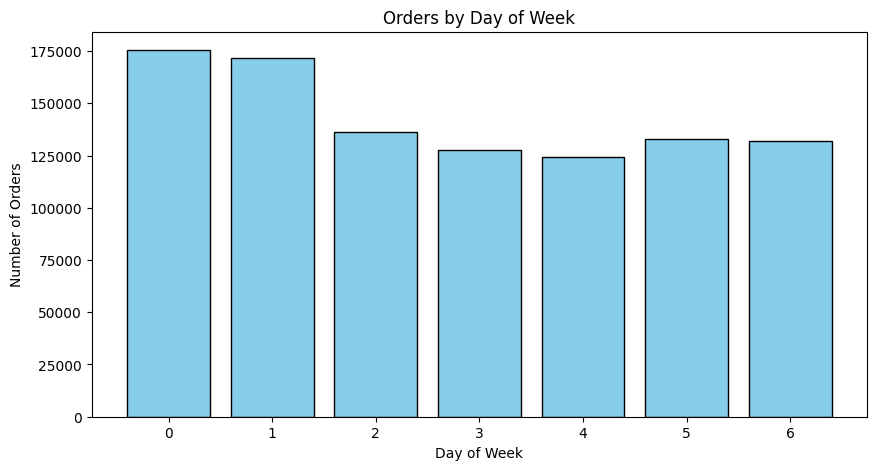

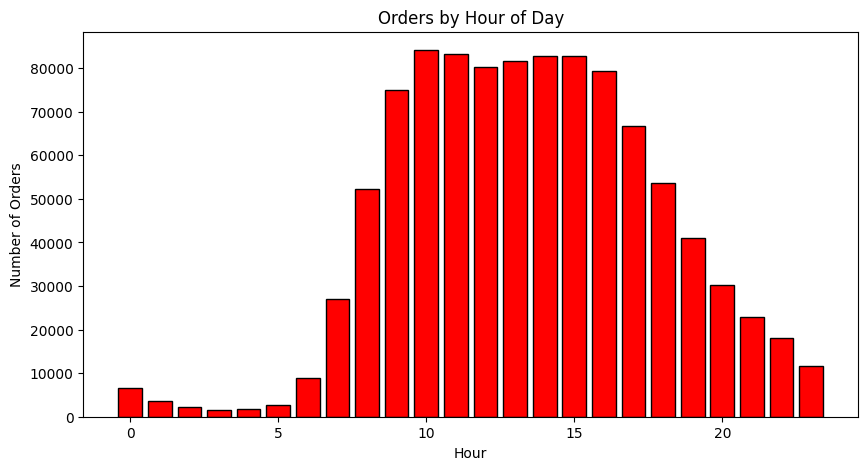

In [6]:
plt.figure(figsize=(10, 5))
day_counts = orders['order_dow'].value_counts().sort_index()
plt.bar(day_counts.index, day_counts.values, color='skyblue', edgecolor='black')
plt.title('Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

plt.figure(figsize=(10, 5))
hour_counts = orders['order_hour_of_day'].value_counts().sort_index()
plt.bar(hour_counts.index, hour_counts.values, color='red', edgecolor='black')
plt.title('Orders by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Orders')
plt.show()

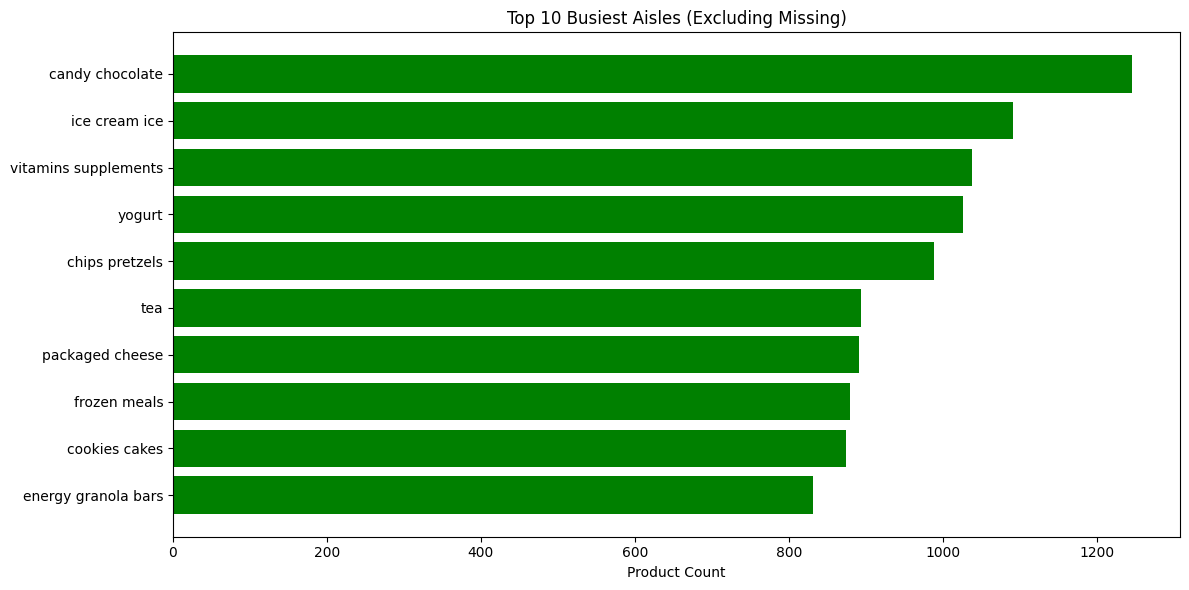

In [7]:
top_aisles = products_merged[products_merged['aisle'] != 'missing']['aisle'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.barh(top_aisles.index, top_aisles.values, color='green')
plt.gca().invert_yaxis()
plt.title('Top 10 Busiest Aisles (Excluding Missing)')
plt.xlabel('Product Count')
plt.tight_layout()
plt.show()

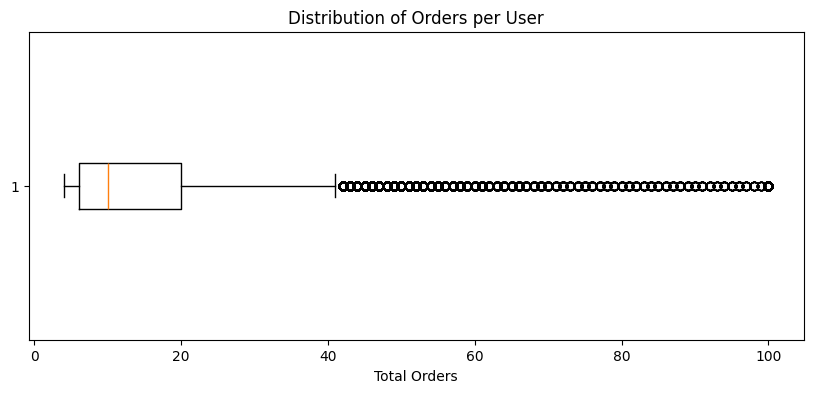

Outlier threshold: 41.0
Total outlier users: 5037


In [8]:
user_orders = orders.groupby('user_id')['order_number'].max()

plt.figure(figsize=(10, 4))
plt.boxplot(user_orders, vert=False)
plt.title('Distribution of Orders per User')
plt.xlabel('Total Orders')
plt.show()

Q1 = user_orders.quantile(0.25)
Q3 = user_orders.quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR

print(f"Outlier threshold: {upper_limit}")
print(f"Total outlier users: {len(user_orders[user_orders > upper_limit])}")

**-----*Feature* *Engineering* & *Representation*-----**

In [35]:
#  max هون عملت تجميع الطلبات لكل مستخدم وبما انه الطلبات مرتبه اخذت
#حسبت حجم كل سله وربطته بالمستخدم
#اخذت المتوسط الحسابي لاحجام السله


user_features = orders.groupby('user_id')['order_number'].max().reset_index()
user_features.columns = ['user_id', 'user_total_orders']

order_sizes = order_products_prior.groupby('order_id').size().reset_index(name='basket_size')
order_sizes = pd.merge(order_sizes, orders[['order_id', 'user_id']], on='order_id')

user_basket_avg = order_sizes.groupby('user_id')['basket_size'].mean().reset_index()
user_basket_avg.columns = ['user_id', 'user_avg_basket_size']
#------------------------------------------------------------------------------------------------------------------------
#ربطت المتجات بالمستخدمين
user_reorder_ratio = pd.merge(order_products_prior, orders[['order_id', 'user_id']], on='order_id')
# حسبت نسبه اعاده الشراء عشان اعرف نسبه ولاء العميل
user_reorder_stats = user_reorder_ratio.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_stats.columns = ['user_id', 'user_reorder_ratio']
#-------------------------------------------------------------------------------------------------------------------------
#حسبت اكتر يوم تكرار عشان اقدر اعتبره اليوم المفضل للتسوق لكل مستخدم ممكن استخدمها بالخصومات او اعلانات بهاض اليوم
user_fav_day = orders.groupby('user_id')['order_dow'].agg(lambda x: x.value_counts().index[0]).reset_index()
user_fav_day.columns = ['user_id', 'user_favorite_dow']

user_df = pd.merge(user_features, user_basket_avg, on='user_id', how='left')
user_df = pd.merge(user_df, user_reorder_stats, on='user_id', how='left')
user_df = pd.merge(user_df, user_fav_day, on='user_id', how='left')

print(user_df.head(9))

   user_id  user_total_orders  user_avg_basket_size  user_reorder_ratio  \
0        1                 11                   NaN                 NaN   
1        2                 15                   NaN                 NaN   
2        3                 13                   NaN                 NaN   
3        4                  6                   2.0            0.000000   
4        5                  5                   NaN                 NaN   
5        6                  4                   NaN                 NaN   
6        7                 21                  11.0            0.818182   
7        8                  4                   NaN                 NaN   
8        9                  4                   NaN                 NaN   

   user_favorite_dow  
0                  4  
1                  1  
2                  0  
3                  4  
4                  3  
5                  5  
6                  0  
7                  1  
8                  1  


In [37]:
#حولت القيم ال (nan)
#لصفر عشان تكون منطقيه اكثر

user_df['user_avg_basket_size'] = user_df['user_avg_basket_size'].fillna(0)
user_df['user_reorder_ratio'] = user_df['user_reorder_ratio'].fillna(0)

print(user_df[['user_avg_basket_size', 'user_reorder_ratio']].isnull().sum())

print(user_df.head(9))

user_avg_basket_size    0
user_reorder_ratio      0
dtype: int64
   user_id  user_total_orders  user_avg_basket_size  user_reorder_ratio  \
0        1                 11                   0.0            0.000000   
1        2                 15                   0.0            0.000000   
2        3                 13                   0.0            0.000000   
3        4                  6                   2.0            0.000000   
4        5                  5                   0.0            0.000000   
5        6                  4                   0.0            0.000000   
6        7                 21                  11.0            0.818182   
7        8                  4                   0.0            0.000000   
8        9                  4                   0.0            0.000000   

   user_favorite_dow  
0                  4  
1                  1  
2                  0  
3                  4  
4                  3  
5                  5  
6                  0  


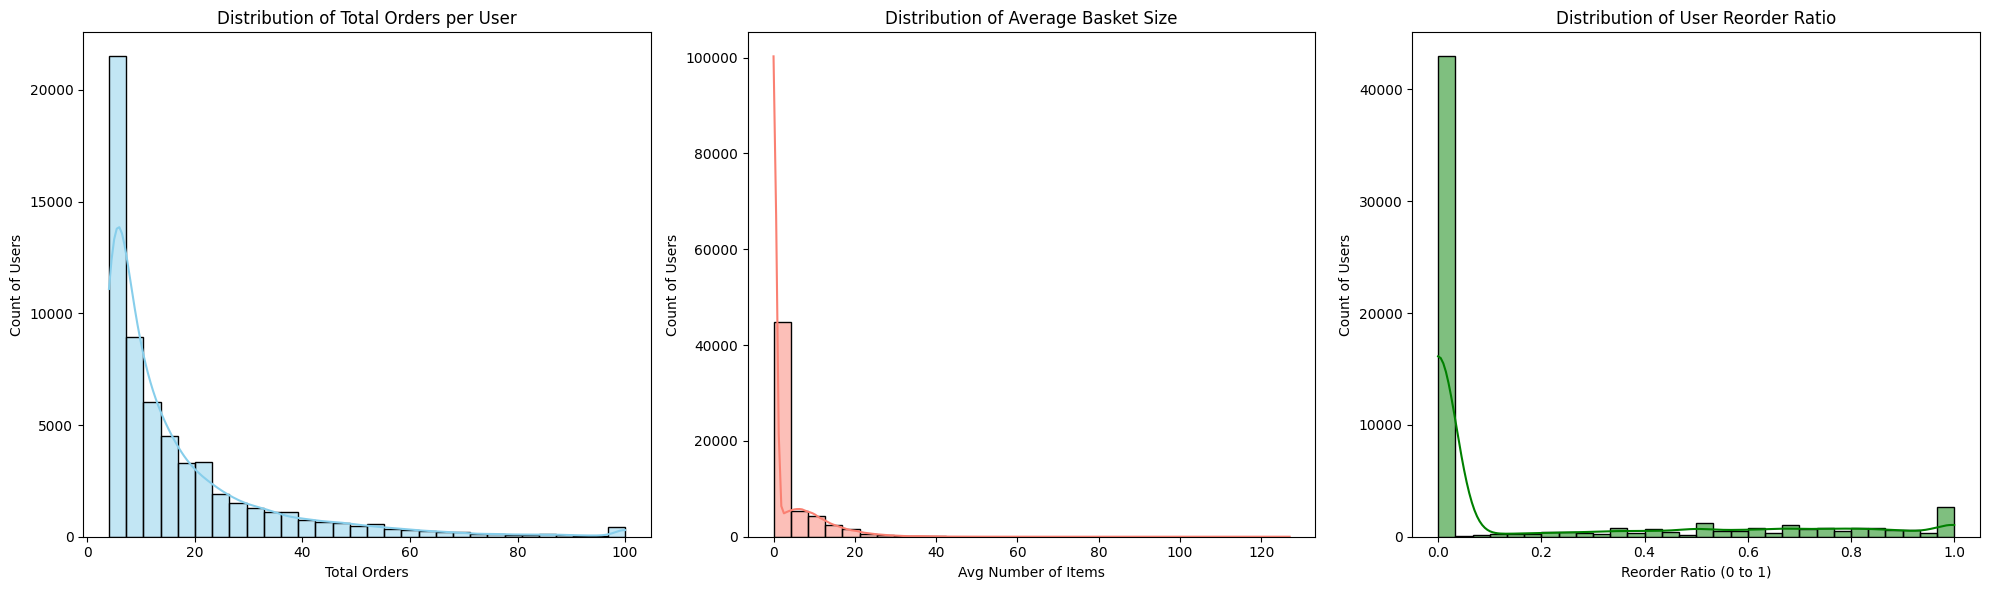

/tmp/ipython-input-2030256184.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='user_favorite_dow', data=user_df, palette='viridis')


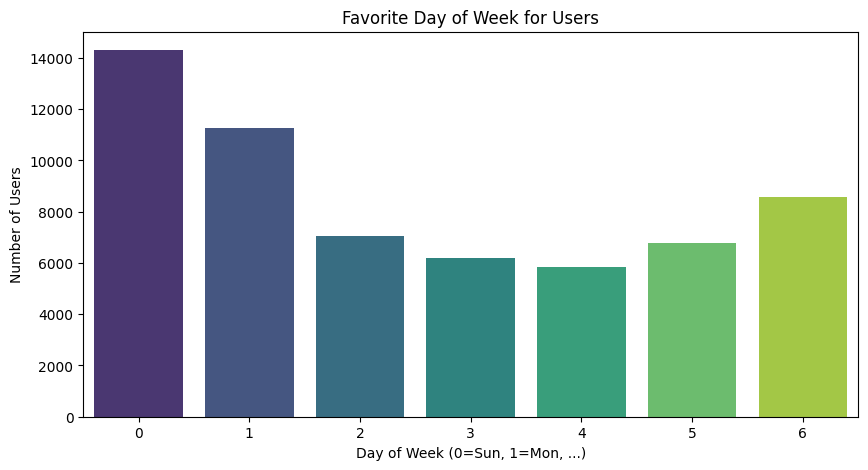

In [38]:
# هون جهزت شكل الرسمة وقسمتها لـ 3 أجزاء بصف واحد عشان أقارن التوزيعات مع بعض
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

#  رسمت توزيع  الطلبات عشان أشوف هل أغلب المستخدمين جداد ولا قدام وعندهم طلبات كتير ولا لا
sns.histplot(user_df['user_total_orders'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Total Orders per User')
axes[0].set_xlabel('Total Orders')
axes[0].set_ylabel('Count of Users')

# هون بشوف حجم السلة المعتاد، يعني بالعربي الناس كم قطعة بتحط في كيس التسوق بالمتوسط
sns.histplot(user_df['user_avg_basket_size'], bins=30, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Average Basket Size')
axes[1].set_xlabel('Avg Number of Items')
axes[1].set_ylabel('Count of Users')

# حسبت توزيع نسبة إعادة الشراء عشان أعرف هل العملاء بكرروا نفس المنتجات ولا كل مرة بيجربوا شي جديد
sns.histplot(user_df['user_reorder_ratio'], bins=30, kde=True, ax=axes[2], color='green')
axes[2].set_title('Distribution of User Reorder Ratio')
axes[2].set_xlabel('Reorder Ratio (0 to 1)')
axes[2].set_ylabel('Count of Users')

plt.tight_layout()
plt.show()

# عملت رسمة للأيام عشان أكشف شو هو اليوم المميز للتسوق عند أغلب المستخدمين عشان ممكن استخدمخ بالنسويق
plt.figure(figsize=(10, 5))
sns.countplot(x='user_favorite_dow', data=user_df, palette='viridis')
plt.title('Favorite Day of Week for Users')
plt.xlabel('Day of Week (0=Sun, 1=Mon, ...)')
plt.ylabel('Number of Users')
plt.show()

In [39]:
# 1. معدل إعادة الطلب الإجمالي للمنتج (Overall Product Reorder Rate)
# هون بحسب كل منتج شو احتمالية إن الناس ترجع تشتريه مرة ثانية.. المنتج اللي نسبته عالية بكون "أساسي" بالبيت
product_reorder_rate = order_products_prior.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_rate.columns = ['product_id', 'p_reorder_rate']

# 2. متوسط ترتيب المنتج في السلة (Average Position in Cart)
# الميزة هاي ذكية! بتكشف إذا المنتج هو "أول شي بيفكر فيه العميل" (بكون ترتيبه 1 أو 2) أو هو "تكملة عدد" بينحط بآخر السلة
product_pos_cart = order_products_prior.groupby('product_id')['add_to_cart_order'].mean().reset_index()
product_pos_cart.columns = ['product_id', 'p_avg_cart_position']

# 3. شعبية المنتج (Total Times Ordered)
# ببساطة بشوف كم مرة انطلب هالمنتج عشان أعرف الـ "Best Sellers" أو المنتجات الأكثر مبيعاً بالسوق
product_popularity = order_products_prior.groupby('product_id').size().reset_index(name='p_total_orders')

# هون دمجت كل المعلومات اللي طلعتها مع جدول المنتجات الأصلي عشان أربط الأرقام بأسماء المنتجات وأقسامها
product_features = pd.merge(products_merged, product_reorder_rate, on='product_id', how='left')
product_features = pd.merge(product_features, product_pos_cart, on='product_id', how='left')
product_features = pd.merge(product_features, product_popularity, on='product_id', how='left')

# تنظيف البيانات: لو في منتج ولا مرة انطلب، بحط مكانه 0 بدل ما تضل الخانة فاضية وتخرب حسابات الموديل بعدين
product_features[['p_reorder_rate', 'p_avg_cart_position', 'p_total_orders']] = product_features[['p_reorder_rate', 'p_avg_cart_position', 'p_total_orders']].fillna(0)

print(product_features.head())

تم إنشاء ميزات المنتج بنجاح:
   product_id                                       product_name  \
0           1                         Chocolate Sandwich Cookies   
1           2                                   All-Seasons Salt   
2           3               Robust Golden Unsweetened Oolong Tea   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4           5                          Green Chile Anytime Sauce   

                        aisle department  p_reorder_rate  p_avg_cart_position  \
0               cookies cakes     snacks        0.694915             5.457627   
1           spices seasonings     pantry        0.000000            12.000000   
2                         tea  beverages        0.666667             3.000000   
3                frozen meals     frozen        0.300000             9.000000   
4  marinades meat preparation     pantry        0.000000             0.000000   

   p_total_orders  
0            59.0  
1             3.0  
2             3

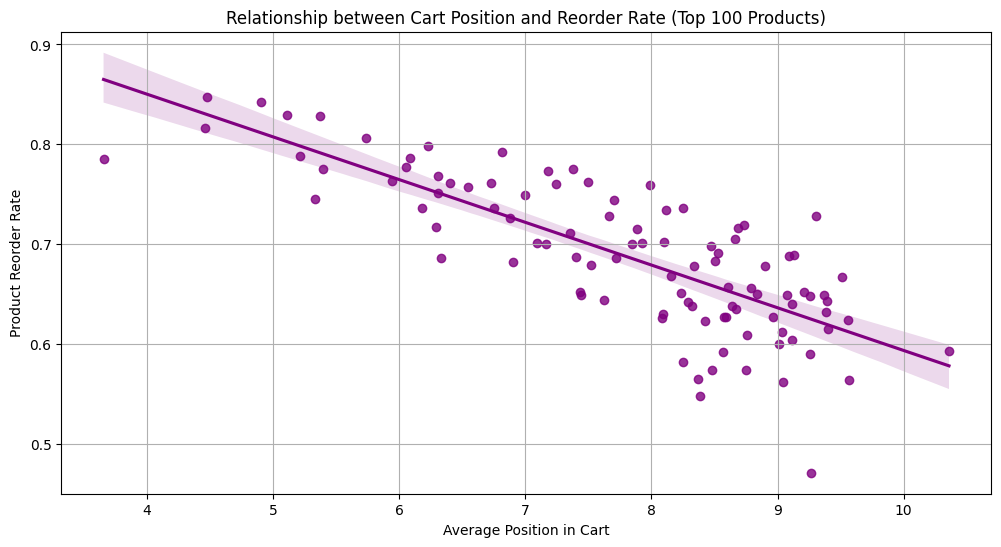

In [40]:
plt.figure(figsize=(12, 6))

#  اخترت أكبر 100 منتج عليهم طلب عشان الرسمة ما تطلع "عجقة" وتكون النتائج منطقية ومبنية على بيانات قوية
top_products = product_features.nlargest(100, 'p_total_orders')

#  رسمت العلاقة بين "ترتيب المنتج بالسلة" و "نسبة إعادة الشراء"
#  رح يورجينا هل في علاقة قوية بينهم ولا لا
sns.regplot(x='p_avg_cart_position', y='p_reorder_rate', data=top_products, color='purple')


plt.title('Relationship between Cart Position and Reorder Rate (Top 100 Products)')
plt.xlabel('Average Position in Cart')
plt.ylabel('Product Reorder Rate')
plt.grid(True)
plt.show()

In [41]:
#  هون بحسب "العلاقة الخاصة" بين كل مستخدم ومنتج
# كم مرة هاد العميل اشترى هاد المنتج بالذات؟ واذا برجع بكرو
user_product_interaction = order_products_prior.merge(orders[['order_id', 'user_id', 'days_since_prior_order']], on='order_id')

up_features = user_product_interaction.groupby(['user_id', 'product_id']).agg(
    up_purchase_count=('order_id', 'count'), # عدد مرات شراء المستخدم لهاد المنتج
    up_reorder_ratio=('reordered', 'mean')   # احتمالية إن العميل يرجع يطلب هاد المنتج بالذات
).reset_index()

#  ميزة "الوقت الضائع": كم صار له العميل ما اشترى هاد المنتج؟
# هاي الميزة بتعرفنا إذا المنتج خلص من عند الزبون ولازم نذكره فيه
user_product_interaction = user_product_interaction.sort_values(['user_id', 'order_id'])

# جبت رقم آخر طلب عمله كل مستخدم ورقم الطلب اللي اشترى فيه المنتج لآخر مرة
last_order_number = orders.groupby('user_id')['order_number'].max().reset_index()
last_purchase_order = user_product_interaction.groupby(['user_id', 'product_id'])['order_id'].max().reset_index()

# دمجت البيانات عشان أحسب الفرق بين رقم آخر طلب كلي و رقم طلب المنتج"
last_purchase_order = last_purchase_order.merge(orders[['order_id', 'order_number']], on='order_id')
last_purchase_order = last_purchase_order.merge(orders.groupby('user_id')['order_number'].max().reset_index(name='max_order_num'), on='user_id')

# المعادلة هاي بتعطينا عدد الطلبات اللي مرت والمنتج غايب عن السلة
last_purchase_order['up_orders_since_last'] = last_purchase_order['max_order_num'] - last_purchase_order['order_number']
up_features = up_features.merge(last_purchase_order[['user_id', 'product_id', 'up_orders_since_last']], on=['user_id', 'product_id'], how='left')


print(up_features.head())

   user_id  product_id  up_purchase_count  up_reorder_ratio  \
0        4       22199                  1               0.0   
1        4       25146                  1               0.0   
2        7        4920                  1               1.0   
3        7        4945                  1               1.0   
4        7        8277                  1               1.0   

   up_orders_since_last  
0                     2  
1                     2  
2                     4  
3                     4  
4                     4  


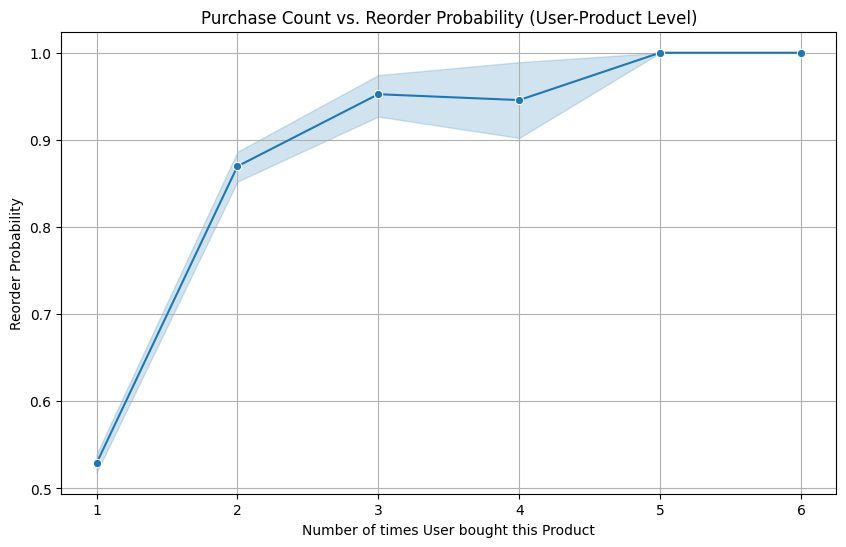

In [42]:
#  العلاقة بين كم مرة اشترى المستخدم هاد المنتج وبين احتمالية إنه يرجع يطلبه
plt.figure(figsize=(10, 6))

sns.lineplot(data=up_features.sample(10000), x='up_purchase_count', y='up_reorder_ratio', marker='o')

plt.title('Purchase Count vs. Reorder Probability (User-Product Level)')
plt.xlabel('Number of times User bought this Product')
plt.ylabel('Reorder Probability')
plt.grid(True)
plt.show()

In [27]:
# 1. استخراج الساعة واليوم (موجودة أصلاً ولكن سنقوم بتنظيمها)
# نستخدم جدول orders الأساسي
temporal_features = orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']].copy()

# 2. تحديد وقت اليوم (صباح، ظهر، مساء، ليل) - ميزة زمنية قوية
def get_day_part(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

temporal_features['day_part'] = temporal_features['order_hour_of_day'].apply(get_day_part)

# 3. ميزة عطلة نهاية الأسبوع (Weekend Flag)
# عادة يوم 0 و 1 هما السبت والأحد وهما أيام الذروة في Instacart
temporal_features['is_weekend'] = temporal_features['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)

# 4. محاكاة "الموسم" (Seasonality) بناءً على تراكم الأيام
# بما أن البيانات لا تحتوي على شهور، سنحسب "الأيام التراكمية" لكل مستخدم
# ونفترض بداية وهمية للسنة لنرى تقلب السلوك
temporal_features['cum_days'] = temporal_features.groupby('user_id')['days_since_prior_order'].cumsum()
temporal_features['approx_month'] = (temporal_features['cum_days'] // 30) % 12
temporal_features['season'] = temporal_features['approx_month'].apply(
    lambda x: 'Winter' if x in [11, 0, 1] else
              'Spring' if x in [2, 3, 4] else
              'Summer' if x in [5, 6, 7] else 'Fall'
)

print("تم إنشاء الميزات الزمنية بنجاح:")
print(temporal_features[['order_id', 'day_part', 'is_weekend', 'season']].head())

تم إنشاء الميزات الزمنية بنجاح:
   order_id   day_part  is_weekend  season
0   2539329    morning           0  Winter
1   2398795    morning           0  Winter
2    473747  afternoon           0  Winter
3   2254736    morning           0  Spring
4    431534  afternoon           0  Spring


In [43]:
# هون جهزت الأعمدة اللي فيها "الوقت" من جدول الطلبات عشان أبدأ اسفيد منهاى
temporal_features = orders[['order_id', 'user_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']].copy()

#  قسمت اليوم لفترات (صباح، ظهر، مساء، ليل)
# هاي الميزة قوية لأن سلوك الناس بالصبح بيختلف تماماً عن سلوكهم بالليل
def get_day_part(hour):
    if 5 <= hour < 12: return 'morning'
    elif 12 <= hour < 17: return 'afternoon'
    elif 17 <= hour < 21: return 'evening'
    else: return 'night'

temporal_features['day_part'] = temporal_features['order_hour_of_day'].apply(get_day_part)

# 3. ميزة "الويكند" (Weekend Flag)
#------------------------------------------------- في Instacart، يوم 0 و 1 هم أيام الزحمة، وهون الموديل بيميز إذا هاد الطلب "طلبية أسبوعية كبيرة" أو طلبية بنص الأسبوع
temporal_features['is_weekend'] = temporal_features['order_dow'].apply(lambda x: 1 if x in [0, 1] else 0)

# 4. اختراع "المواسم" (Seasonality)
# بما إنه ما عنا تواريخ حقيقية، استخدمت ذكاءك وحسبت "الأيام التراكمية" عشان نقدر نتخيل تغير الفصول
# هاي الميزة بتفيدنا مستقبلاً لو بدنا نعرف مين بشتري "بوظة" بالصيف أو "شوربات" بالشتاء
temporal_features['cum_days'] = temporal_features.groupby('user_id')['days_since_prior_order'].cumsum()
temporal_features['approx_month'] = (temporal_features['cum_days'] // 30) % 12
temporal_features['season'] = temporal_features['approx_month'].apply(
    lambda x: 'Winter' if x in [11, 0, 1] else
              'Spring' if x in [2, 3, 4] else
              'Summer' if x in [5, 6, 7] else 'Fall'
)

print(temporal_features[['order_id', 'day_part', 'is_weekend', 'season']].head())

   order_id   day_part  is_weekend  season
0   2539329    morning           0  Winter
1   2398795    morning           0  Winter
2    473747  afternoon           0  Winter
3   2254736    morning           0  Spring
4    431534  afternoon           0  Spring


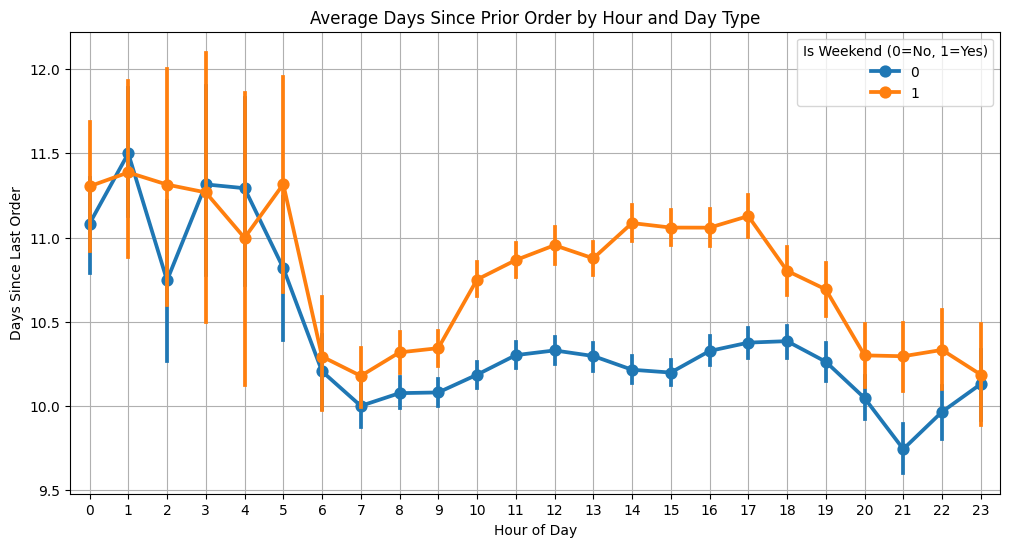

In [44]:
plt.figure(figsize=(12, 6))

# 1. استخدمت pointplot عشان أرسم "نقاط الاتجاه" وأشوف كيف بتتحرك الفجوة الزمنية بين الطلبات
# قارنت بين ساعات اليوم (x) وبين (كم يوم مر على آخر طلب) (y)
# والـ hue='is_weekend' خلتنا نفرق بوضوح بين سلوك الناس في الويكند وأيام الشغل
sns.pointplot(data=temporal_features, x='order_hour_of_day', y='days_since_prior_order', hue='is_weekend')

# هون حطيت العناوين والتوضيحات عشان أي حد يشوف الرسمة يفهم شو الفرق بين الـ 0 والـ 1
plt.title('Average Days Since Prior Order by Hour and Day Type')
plt.xlabel('Hour of Day')
plt.ylabel('Days Since Last Order')
plt.legend(title='Is Weekend (0=No, 1=Yes)')
plt.grid(True)
plt.show()

# **TASK A:**

# **TASK B:**